Задачу предсказания состояния можно разбить на несколько.
1) Определяем есть ли det.
2) Опеределяем цвет.
3) Определяем proof
4) Определяем численно сохранность для монет без det.
5) Определяем численно сохранность для монет c det.

In [1]:
import pandas as pd
import time
from tqdm import tqdm
import re
import os
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow import keras

In [2]:
path = 'D:\\Python\\' 
labels = pd.read_csv(path + 'coin_data_final.csv',index_col='Unnamed: 0')
labels['condition'].unique()

array(['AU58BN', 'AU55', 'F det.', 'AU58', 'AU det.', 'ХF det.', 'MS66RB',
       'AU53', 'MS60BN', 'MS62BN', 'MS60', 'AU50', 'UNC det.', 'MS61BN',
       'XF45', 'MS62', 'MS64', 'MS63', 'MS61', 'MS65', 'AU55BN', 'MS64RB',
       'MS65RB', 'MS64BN', 'PL63', 'MS61RB', 'MS66', 'MS65RD', 'MS66RD',
       'MS64RD', 'MS63RB', 'MS63BN', 'XF40', 'VF det.', 'MS67', 'MS65BN',
       'MS66BN', 'VF35', 'VF30', 'MS69', 'MS68', 'VF25', 'VG det.', 'F15',
       'MS70', 'PF70', 'VF20', 'PL65', 'PF64', 'PF69', 'PL61', 'PF60',
       'PF68', 'PF67', 'PF65', 'PF62', 'PF det.', 'PL62', 'AU53BN',
       'PL64', 'PL68', 'PL67', 'PL69', 'PF66', 'XF45BN', 'XF40BN',
       'VF30BN', 'AU50BN', 'VF35BN', 'VF25BN', 'PF63', 'PF63BN', 'PF65BN',
       'PF64BN', 'PL65RB', 'PF63RD', 'MS62RB', 'MS63RD', 'PL64BN',
       'MS61RD', 'PL66', 'PF61', 'VG8', 'F12', 'PF67RD', 'F15BN',
       'PL65RD', 'MS62RD', 'AU58RB', 'PL70', 'PF64RB', 'PL60', 'PF61BN',
       'PF66RD', 'G det.', 'PF63RB', 'PF64RD', 'MS60RB', 'MS67RD',
 

In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115227 entries, 0 to 121109
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   number     115227 non-null  object 
 1   weight     115227 non-null  float64
 2   date       115227 non-null  object 
 3   year       114763 non-null  object 
 4   condition  115227 non-null  object 
 5   value      115227 non-null  object 
 6   text       42268 non-null   object 
 7   det        115227 non-null  bool   
 8   revers     115227 non-null  object 
 9   avers      115227 non-null  object 
dtypes: bool(1), float64(1), object(8)
memory usage: 8.9+ MB


# Предобработка

In [4]:
labels.loc[labels['condition'].str.find('BN')>0,'color'] = 0
labels.loc[labels['condition'].str.find('RB')>0,'color'] = 1
labels.loc[labels['condition'].str.find('RD')>0,'color'] = 2

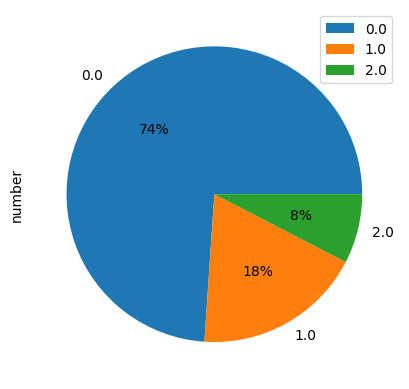

In [17]:
labels.pivot_table(index='color',values='number',aggfunc='count').plot(kind='pie',y='number',autopct='%1.0f%%')
plt.show()

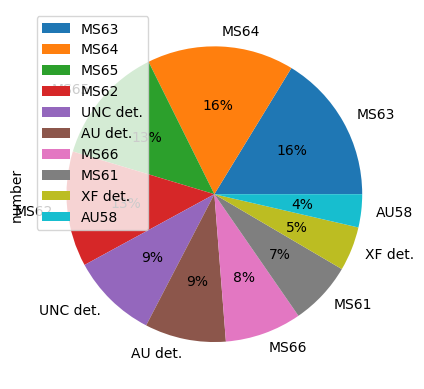

In [27]:
labels.pivot_table(index='condition',values='number',aggfunc='count').sort_values(by='number',ascending=False).head(10).plot(kind='pie',y='number',autopct='%1.0f%%')
plt.show()

In [41]:
table_condition = labels.pivot_table(index='condition',values='number',aggfunc='count').sort_values(by='number',ascending=False)
table_condition.loc[table_condition['number']<16]

,number
condition,
VF20BN,13
VG8,12
PF62BN,12
VG10,12
PF64RB,11
PF66RD,10
PF63RB,9
PF65RD,7
MS60RB,7


In [94]:
det_scale = {'G det.':0,'VG det.':1,'F det.':2, 'VF det.':3,'ХF det.':4,'AU det.':5,'UNC det.':6}

sheldon_scale = {'G4':0,'G6':1,'VG8':2,'VG10':3,'F12':4,'F15':5,'VF20':6,'VF25':7,'VF30':8,'VF35':9,'XF40':10,'XF45':11,\
                'AU50':12,'AU53':13,'AU55':14,'AU58':15,'MS60':15,'MS61':17,'MS62':18,'MS63':19,'MS64':20,'MS65':21,'MS66':22,\
                'MS67':23,'MS68':24,'MS69':25,'MS70':26}

sheldon_list = ['G4','G6','VG8','VG10','F12','F15','VF20','VF25','VF30','VF35','XF40','XF45',\
                'AU50','AU53','AU55','AU58','MS60','MS61','MS62','MS63','MS64','MS65','MS66',\
                'MS67','MS68','MS69','MS70']

# Анализ

Посмотрим на распределение монет по годам. 

<Axes: >

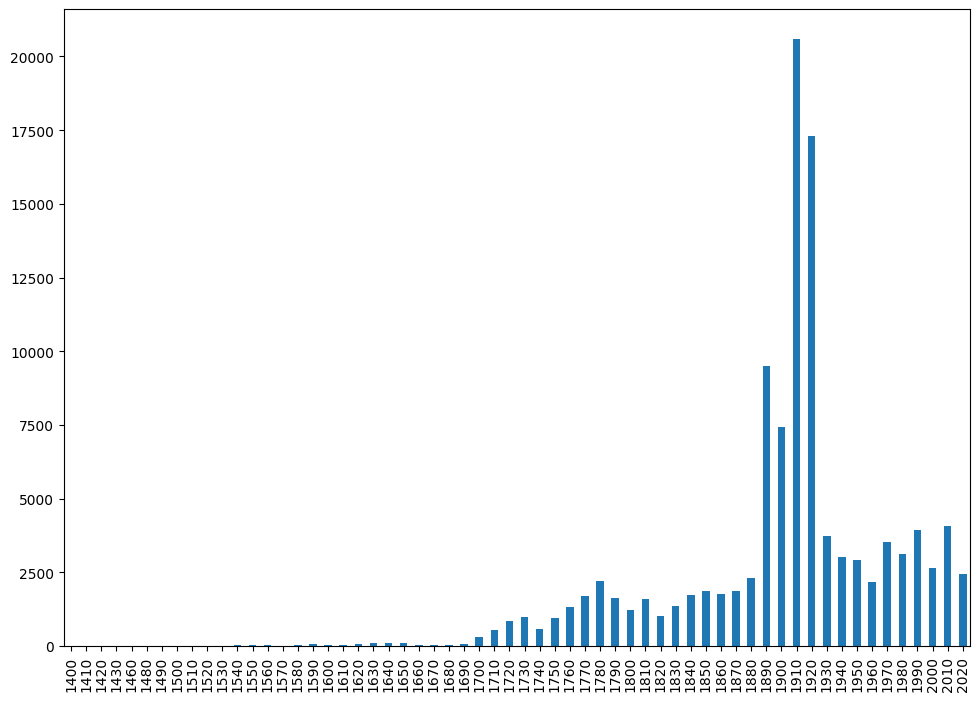

In [46]:
data_year = labels[['year']].dropna()
data_year = data_year.loc[data_year['year'].str.isdigit(),'year'].astype('int')
data_year = data_year.loc[data_year<2030]
plt.figure(figsize=(11.7,8.27))
data_year.apply(lambda x: 10*(x // 10)).value_counts().sort_index().tail(60).plot.bar()

Поскольку методы чеканки изменялись со временем, то есть смысл ограничиться только монетами чеканенными винтовыми прессами. т.е. после 1700г.

In [48]:
data_year.loc[data_year>=1700].count()

2756

Удалим монеты старше 1700г.

In [50]:
data_year = data_year.loc[data_year>=1700]
labels = labels.loc[labels.index.isin(data_year.index)]
labels['year']=labels['year'].astype('int')
labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112017 entries, 0 to 121109
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   number     112017 non-null  object 
 1   weight     112017 non-null  float64
 2   date       112017 non-null  object 
 3   year       112017 non-null  int32  
 4   condition  112017 non-null  object 
 5   value      112017 non-null  object 
 6   text       39957 non-null   object 
 7   det        112017 non-null  bool   
 8   revers     112017 non-null  object 
 9   avers      112017 non-null  object 
dtypes: bool(1), float64(1), int32(1), object(7)
memory usage: 8.2+ MB


In [51]:
labels['year'].min(), labels['year'].max()

(1700, 2025)

# Определяем det.

Довольно большое количество оченок монет содержат det.

In [54]:
labels.loc[labels['det']].shape[0]

17677

In [83]:
labels['det'] = labels['det'].astype('str')

In [90]:
def load_train(path):

    datagen = ImageDataGenerator(
        validation_split=0.85,
        rescale=1/255.
    )

    return datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path+'coin_pages/',
        x_col='revers',
        y_col='det',
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary',
        subset='training',
        seed=123
    )


def load_test(path):
   

    datagen = ImageDataGenerator(
        validation_split=0.025,
        rescale=1/255.)

    return datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'coin_pages/',
        x_col='revers',
        y_col='det',
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary',
        subset='validation',
        seed=123
    )


def create_model(input_shape):
    backbone = ResNet50(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False)
    
    #замораживаем ResNet50 без верхушки
    backbone.trainable = False
    for layer in backbone.layers[-5:]:
        layer.trainable = True
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model


def train_model(model, train_data, test_data, batch_size=50, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    
    model.fit(train_data,
        validation_data=test_data,
        epochs=epochs, batch_size=batch_size,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2, shuffle=True)
    return model

In [91]:
path = 'D:\\Python\\' 
train_data = load_train(path)
test_data = load_test(path)
model = create_model([224, 224, 3])

Found 16803 validated image filenames belonging to 2 classes.
Found 2800 validated image filenames belonging to 2 classes.


In [92]:
train_model(model, train_data, test_data)

Epoch 1/10


D:\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


526/526 - 666s - 1s/step - accuracy: 0.8414 - loss: 0.4209 - val_accuracy: 0.8368 - val_loss: 0.4303
Epoch 2/10


KeyboardInterrupt: 

# Оценка

In [97]:
labels = labels.loc[labels['condition'].isin(sheldon_list)]
labels['int']= labels['condition'].replace(to_replace=sheldon_scale)
labels.head()

C:\Users\andre\AppData\Local\Temp\ipykernel_21588\670913982.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels['int']= labels['condition'].replace(to_replace=sheldon_scale)


,number,weight,date,year,condition,value,text,det,revers,avers,int
1,AA0509,2.79,11.11.2020,1733,AU55,Гривенник 1733,Биткин 184 (R),False,AA0509r.jpg,AA0509a.jpg,14
3,AA1075,25.71,14.01.2021,1734,AU55,Рубль 1734,"""Тип 1735 года"", с кулоном на груди",False,AA1075r.jpg,AA1075a.jpg,14
4,AA1076,25.33,14.01.2021,1738,AU58,Рубль 1738,"Биткин 232 (R) ""Петербургский тип""",False,AA1076r.jpg,AA1076a.jpg,15
10,AA1902,24.83,27.01.2021,1733,AU53,Рубль 1733,дефект заготовки,False,AA1902r.jpg,AA1902a.jpg,13
18,AA3367,25.98,19.12.2022,1737,MS60,Рубль 1737,С кулоном на груди,False,AA3367r.jpg,AA3367a.jpg,15


In [85]:
labels['int'].unique()

array([14, 15, 13, 12, 11, 18, 20, 19, 17, 21, 22, 10, 23,  9,  8, 25, 24,
        7,  5, 26,  6,  2,  4,  3,  0,  1], dtype=int64)

In [98]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68357 entries, 1 to 121109
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   number     68357 non-null  object 
 1   weight     68357 non-null  float64
 2   date       68357 non-null  object 
 3   year       68357 non-null  int32  
 4   condition  68357 non-null  object 
 5   value      68357 non-null  object 
 6   text       16446 non-null  object 
 7   det        68357 non-null  object 
 8   revers     68357 non-null  object 
 9   avers      68357 non-null  object 
 10  int        68357 non-null  int64  
dtypes: float64(1), int32(1), int64(1), object(8)
memory usage: 6.0+ MB


### Модель для предсказания числовой оценки состояния монеты. На всходе оценки только с числом. 

In [99]:
def load_train(path):

    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.
    )

    return datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path+'coin_pages/',
        x_col='revers',
        y_col='int',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=123
    )


def load_test(path):
   

    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.)

    return datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'coin_pages/',
        x_col='revers',
        y_col='int',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=123
    )


def create_model(input_shape):
    backbone = ResNet50(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False)
    
    #замораживаем ResNet50 без верхушки
    backbone.trainable = False
    for layer in backbone.layers[-5:]:
        layer.trainable = True
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=Adam(learning_rate=0.0003), 
                  loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model


def train_model(model, train_data, test_data, batch_size=50, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    
    model.fit(train_data,
        validation_data=test_data,
        epochs=epochs, batch_size=batch_size,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2, shuffle=True)
    return model

In [100]:
path = 'D:\\Python\\' 
train_data = load_train(path)
test_data = load_test(path)
model = create_model([224, 224, 3])

Found 51268 validated image filenames.
Found 17089 validated image filenames.


In [101]:
train_model(model, train_data, test_data)

Epoch 1/10


D:\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1603/1603 - 2270s - 1s/step - loss: 18.0470 - mean_absolute_error: 2.9681 - val_loss: 7.1980 - val_mean_absolute_error: 2.0614
Epoch 2/10
1603/1603 - 2311s - 1s/step - loss: 7.5106 - mean_absolute_error: 2.0629 - val_loss: 7.8109 - val_mean_absolute_error: 2.0194
Epoch 3/10
1603/1603 - 2139s - 1s/step - loss: 7.1253 - mean_absolute_error: 2.0131 - val_loss: 8.2924 - val_mean_absolute_error: 2.1018
Epoch 4/10


KeyboardInterrupt: 

In [32]:
model.save("D:\\Python\\1.keras")

In [30]:
def load_train(path):

    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.
    )

    return datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path+'coin_pages/',
        x_col='revers',
        y_col='det',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=123
    )


def load_test(path):
   

    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.)

    return datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'coin_pages/',
        x_col='revers',
        y_col='det',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=123
    )


def create_model(input_shape):
    backbone = ResNet50(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False)
    
    #замораживаем ResNet50 без верхушки
    backbone.trainable = False
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.01), 
                  loss='sparse_categorical_crossentropy', metrics=['acc'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    
    model.fit(train_data,
        validation_data=test_data,
        epochs=epochs, batch_size=batch_size,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2, shuffle=True)
    return model

In [ ]:
path = 'D:\\Python\\' 
train_data = load_train(path)
test_data = load_test(path)
model = create_model([224, 224, 3])
train_model(model, train_data, test_data)

In [29]:
labels = labels.loc[labels['color']>=0]

In [53]:
def load_train(path):

    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.
    )

    return datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path+'coin_pages/',
        x_col='revers',
        y_col='color',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=123
    )


def load_test(path):
   

    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.)

    return datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'coin_pages/',
        x_col='revers',
        y_col='color',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=123
    )


def create_model(input_shape):
    backbone = ResNet50(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False)
    
    #замораживаем ResNet50 без верхушки
    backbone.trainable = False
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1024, activation='sigmoid'))
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=Adam(learning_rate=0.01), 
                  loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    
    model.fit(train_data,
        validation_data=test_data,
        epochs=epochs, batch_size=batch_size,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2, shuffle=True)
    return model

In [43]:
train_data = load_train(path)
test_data = load_test(path)
model = create_model([224, 224, 3])
train_model(model, train_data, test_data)

### Модель с двумя изображениями на монету.

In [49]:
import pandas as pd
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

img_size = (224,224)

# Загрузка данных

def load_train(path,side):

    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.
    )

    return datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path+'coin_pages/',
        x_col=side,
        y_col='int',
        target_size=img_size,
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=123
    )


def load_test(path,side):
   

    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.)

    return datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'coin_pages/',
        x_col=side,
        y_col='int',
        target_size=img_size,
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=123
    )
input = Input(shape=(*img_size, 3))

# Функция для создания модели
def create_base_model(input):

    # Загрузка предобученной модели ResNet50 без верхнего слоя
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input)

    # Заморозка слоев предобученной модели
    for layer in base_model.layers:
        layer.trainable = False

    # Добавление новых слоев поверх ResNet50
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    x = Dense(64, activation='relu')(x)
    output = Dense(1)(x) # Используем линейную активацию для регрессии

    return model

model = create_base_model(input)
preds_avers = model.predict(load_train(path,'avers'))
preds_revers = model.predict(load_train(path,'revers'))


def create_model():
    
    # Создание модели
    model = Model(inputs=[preds_avers, preds_revers], outputs=(output_avers+output_revers)/2)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['mae'])

    return model

# Функция для объединения генераторов
def combined_generator(generator_avers, generator_revers):
    while True:
        X_avers, y_avers = next(generator_avers)
        X_revers, y_revers = next(generator_revers)
        if not np.array_equal(y_avers, y_revers):
            raise ValueError("Labels of avers and revers generators do not match.")
    yield [X_avers, X_revers], y_avers

train_combined_generator = combined_generator(load_train(path,'avers'), load_train(path,'revers'))
val_combined_generator = combined_generator(load_test(path,'avers'), load_test(path,'revers'))

# Функция для обучения модели
def train_model(model, train_data, test_data, batch_size=32, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    
    model.fit(train_data,
        validation_data=test_data,
        epochs=epochs, batch_size=batch_size,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2, shuffle=True)
    return model

# Создание и обучение модели
model = create_model()
history = train_model(model, train_combined_generator, val_combined_generator)

Found 52635 validated image filenames.
Found 52635 validated image filenames.
Found 17545 validated image filenames.
Found 17545 validated image filenames.


NameError: name 'x_avers' is not defined

In [ ]:
# Предсказание на валидационной выборке
val_generator.reset()
predictions = model.predict(val_generator, steps=val_generator.n // val_generator.batch_size, verbose=1)

# Получение реальных значений
true_values = val_generator.classes[:len(predictions)] # Или иной способ получить реальные значения из val_generator

# Вычисление остатков
residuals = true_values - predictions.flatten()

# Построение графиков остатков
plt.figure(figsize=(12, 6))

# График остатков
plt.subplot(1, 2, 1)
plt.scatter(true_values, residuals)
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.title('Residuals vs True Values')
plt.axhline(0, color='red', linestyle='--')

# Гистограмма остатков
plt.subplot(1, 2, 2)
plt.hist(residuals, bins=30)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residual Histogram')

plt.tight_layout()
plt.show()

# Сохранение модели
model.save('preservation_model_resnet.h5')

In [58]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Concatenate, Average
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence

# Предположим, что изображения находятся в папке 'images/'
image_folder = path+'coin_pages/'

# Генератор изображений
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

def create_generator(datagen, subset, side):
    generator = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=image_folder,
        x_col= side,
        y_col='int',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset=subset,
        shuffle=False
        )

    return generator

train_generator_avers = create_generator(datagen, 'training','avers')
train_generator_revers = create_generator(datagen, 'training','revers')
validation_generator_avers =create_generator(datagen, 'validation','avers')
validation_generator_revers = create_generator(datagen, 'validation','revers')

# Создание модели
def build_model():
    input_img = Input(shape=(224, 224, 3))
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_img)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    output = Dense(1)(x)

    model = Model(inputs=input_img, outputs=output)

    return model

base_model = build_model()

# Функция для объединения предсказаний аверса и реверса
def combine_predictions(model, generator_avers, generator_revers):
    preds_avers = model.predict(generator_avers)
    preds_revers = model.predict(generator_revers)
    avg_preds = (preds_avers + preds_revers) / 2
    return avg_preds

print(type(combine_predictions(model, train_generator_avers, train_generator_revers)))

# Настройка модели для обучения
input_avers = Input(shape=(224, 224, 3), name='avers_input')
input_revers = Input(shape=(224, 224, 3), name='revers_input')

output_avers = base_model(input_avers)
output_revers = base_model(input_revers)

avg_output = Average()([output_avers, output_revers])

final_model = Model(inputs=[input_avers, input_revers], outputs=avg_output)
final_model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mae'])

# Создание функции для объединения генераторов 
def create_combined_generator(gen_avers, gen_revers): 
    def generator(): 
        while True: 
            x_avers, y_avers = next(gen_avers) 
            x_revers, y_revers = next(gen_revers) 
            yield ([x_avers, x_revers], y_avers) 
    return generator 
# Создание комбинированных генераторов 
train_combined_generator = tf.data.Dataset.from_generator(
    create_combined_generator(train_generator_avers, train_generator_revers), 
    output_signature=( ( tf.TensorSpec(shape=(32, 224, 224, 3), dtype=tf.float32), 
                        tf.TensorSpec(shape=(32, 224, 224, 3), dtype=tf.float32), ), 
                      tf.TensorSpec(shape=(32,), dtype=tf.float32) ) ) 
val_combined_generator = tf.data.Dataset.from_generator( 
    create_combined_generator(validation_generator_avers, validation_generator_revers), 
    output_signature=( ( tf.TensorSpec(shape=(32, 224, 224, 3), dtype=tf.float32), 
                        tf.TensorSpec(shape=(32, 224, 224, 3), dtype=tf.float32), ), 
                      tf.TensorSpec(shape=(32,), dtype=tf.float32) ) )

# Обучение модели
history = final_model.fit(
    train_combined_generator,
    validation_data=val_combined_generator,
    epochs=10,verbose=2
    )

# Оценка модели
results = final_model.evaluate(val_combined_generator)
print(f'Validation Loss: {results[0]}, Validation MAE: {results[1]}')

Found 56144 validated image filenames.
Found 56144 validated image filenames.
Found 14036 validated image filenames.
Found 14036 validated image filenames.


D:\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  71/1755 ━━━━━━━━━━━━━━━━━━━━ 23:51 850ms/step

KeyboardInterrupt: 